In [1]:
import pandas as pd
from pandas.api.types import is_numeric_dtype
import seaborn as sns
import numpy as np
from scipy.optimize import curve_fit, minimize
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from copy import deepcopy
import einops

from low_dim_capability_space import * 
from utils import *

In [11]:
GSM8K_METHOD_SCALING_COT_METRIC_MAP = {
    'gsm8k_5_exact_match,flexible-extract': "Naive + Greedy",
    'gsm8k_cot_8_exact_match,flexible-extract': "CoT + Greedy",
}

MODELS_PART_4_3 = ['Llama-2', 
                   'llama-', 
                   'Llama-3',
                   'Qwen1.5',
                   'Qwen-',
                   'Mistral',
                   'Mixtral',
                   'Yi',
                   'gemma',
                   'falcon',
                   'phi',
                   'pythia',
                   'bloom',
                   'gpt-',
                   'opt',
                   'mpt',
                   'xglm',
                   'CodeLlama',
                   'starcoderbase',
                   'starcoder2',
                   'deepseek-coder-'
]



def load_eval_scores():
    
    evals = pd.read_csv('leaderboards/base_llm_post_training_eval.csv')

    # Add data from the other leaderboard
    evals_compute = pd.read_csv('leaderboards/base_llm_benchmark_eval.csv')
    evals = evals.merge(evals_compute, on=['Model'])

    return evals


def split_train_test(evals: pd.DataFrame,
                     flops_cutoff: float = 84 
):
    evals['set'] = None
    for i, row in evals.iterrows():
        if row['FLOPs (1E21)'] > flops_cutoff:
            evals.loc[i, 'set'] = 'test'
        else:
            evals.loc[i, 'set'] = 'train'

    return evals


def train_test_pca_imputation(evals: pd.DataFrame,
                              models_names: list[str] = MODELS_PART_4_3,
                              pca_imputation_cols: list = BENCHMARKS
):
    print(f'PCA imputations is applied to columns: {pca_imputation_cols}')
    imputed_evals, _ = pca_imputation(evals,
                                      benchmarks=pca_imputation_cols)
    
    # Remerge and remove duplicate columns
    compute_col = evals['FLOPs (1E21)']
    evals = imputed_evals.merge(evals, left_index=True, right_index=True,
                                how='outer', suffixes=('', '_y'))
    evals.drop(evals.filter(regex='_y$').columns, axis=1, inplace=True)

    evals['log_compute'] = np.log10(compute_col)

    if models_names:
        pattern = '|'.join(models_names)
        evals = evals[evals['Model'].str.contains(pattern, regex=True)]
        print(f"Loaded eval scores for {evals.shape[0]} models")

    return evals


def remove_nan_rows(evals: pd.DataFrame,
                    row: list[str]):
    initial_len = evals.shape[0]
    evals = evals.dropna(subset=row)
    print(f"Removed {initial_len - evals.shape[0]} rows with NaN values")
    return evals
    

def fit_sigmoid(evals: pd.DataFrame,
                benchmark: 'str' = 'gsm8k_5_exact_match,flexible-extract',
                sigmoid_n_params: int = 4,
                n_pcs: int = 3
):
    if 'set' in evals:
        train_set = evals[evals['set'] == 'train']
    eval_scores = train_set[benchmark]


    # Set the initial parameters for the sigmoid function
    L_init = max(eval_scores)  # Maximum value of target data
    x0_init = np.mean(eval_scores)  # Median value of feature data
    k_init = 1  # Initial guess for the steepness
    b_init = min(eval_scores)  # Minimum value of target data
    
    # Remove rows with NaN values for log_compute and benchmark
    train_set = remove_nan_rows(train_set, row=['log_compute', benchmark])
    pcs = [f'PC-{i+1}' for i in range(0, n_pcs)]

    if sigmoid_n_params == 4:
        params, _ = curve_fit(sigmoid, train_set['log_compute'].values, 
                              train_set[benchmark].values, 
                              [L_init, x0_init, k_init, b_init], 
                              maxfev=10000)
        L, x0, k, b = params
        print(f"Fitted parameters: L = {L}, x0 = {x0}, k = {k}, b = {b}")
    elif sigmoid_n_params == 2:
        params, _ = curve_fit(sigmoid_2_params, 
                              train_set[pcs].values,
                              train_set[benchmark].values, 
                              p0=np.concatenate([[0.0], np.ones(n_pcs-1) * 3e-2, [0.0]]), 
                              maxfev=10000)
        print(f"Fitted parameters: beta = {params[0]}, k = {params[1]}")

    return params


In [3]:
def fit_sigmoid_on_benchmark(target_benchmark = 'gsm8k_5_exact_match,flexible-extract',
                             n_pca_components: int = 5,
                             n_pcs: int = 3,):
    """
    TODO n_components = n_pcs ?
    """

    leaderboard = load_eval_scores()
    leaderboard = train_test_pca_imputation(leaderboard, models_names=MODELS_PART_4_3)
    leaderboard = split_train_test(leaderboard)

    train_df = leaderboard[leaderboard["set"] == "train"]
    test_df = leaderboard[leaderboard["set"] == "test"]

    if target_benchmark in BENCHMARKS:
        BENCHMARKS.remove(target_benchmark)

    principal_df_train, _, pca_components, pca, scaler = apply_pca(train_df, 
                                                    benchmarks=BENCHMARKS,
                                                    n_components=n_pca_components, 
                                                    standardize=False)

    # Get test data PCs using previously calculated PCA
    test_data = test_df[BENCHMARKS]
    if scaler is not None:
        scaled_test_data = scaler.transform(test_data)
    else:
        scaled_test_data = test_data
    principal_components_test = pca.transform(scaled_test_data)
    
    principal_df_test = pd.DataFrame(data=principal_components_test, 
                                     columns=[f'PC-{i+1}' for i in range(n_pca_components)],
                                     index=test_df.index)
    
    for n in range(n_pca_components):
        merged_df = pd.DataFrame({
        f'PC-{n+1}': principal_df_train[f'PC-{n+1}'].combine_first(principal_df_test[f'PC-{n+1}'])
        })
        leaderboard[f'PC-{n+1}'] = merged_df[f'PC-{n+1}']

    pcs_col_names = [f'PC-{i+1}' for i in range(n_pcs)]

    # Remove rows with NaN values
    leaderboard = remove_nan_rows(leaderboard, row=[target_benchmark]+pcs_col_names)

    train_df = leaderboard[leaderboard["set"] == "train"]
    X = train_df[pcs_col_names]
    y = train_df[target_benchmark]

    fixed_height = True
    if fixed_height:
        initial_guess = 0.3*np.ones(X.shape[1] + 1)
    else:
        initial_guess = 0.3*np.ones(X.shape[1] + 2)

    # Fit the sigmoid function to the data
    params, _ = curve_fit(sigmoid, X, y, p0=initial_guess, maxfev=10000)

    if fixed_height:
        beta = params[:-1]
        alpha = params[-1]
        h = 1
    else:
        beta = params[:-2]
        alpha = params[-2]
        h = params[-1]

    return (beta, alpha, h), leaderboard

def sigmoid(x,*params):
    if len(params)==4:
        beta = np.array(params[:-1])
        alpha = params[-1]
        h = 1
    elif len(params)==3:
        beta = np.array(params[:-2])
        alpha = params[-2]
        h = params[-1]
    else:
        beta = params[0]
        alpha = params[1]
        h = 1

    return h / (1 + np.exp(-(np.dot(x, beta) + alpha)))

In [4]:
def compute_f_equivalent_flops(leaderboard:pd.DataFrame,
                               beta,
                               alpha: float,
                               benchmark: str,
                               n_pcs: int = 3,
                               reference_family: str = 'Llama-2',
):
    # Fit linear regression on reference family only to get b_f and w_f: P = w_f * log(C) + b_f
    reference_family_leaderboard = leaderboard[leaderboard['Model'].str.contains(reference_family)]
    reference_family_log_compute_values = reference_family_leaderboard['log_compute'].values

    pcs = [f'PC-{i+1}' for i in range(n_pcs)]
    pca_components = reference_family_leaderboard[pcs].values
    P = np.einsum('k, kt -> t', beta, pca_components) + alpha # aggregated capability metric
    
    model1 = LinearRegression()
    model1.fit(reference_family_log_compute_values.reshape(-1, 1), P)
    w_f = model1.coef_ #scalar
    b_f = model1.intercept_ #scalar

    # Compute f_equivalent FLOPs for all models
    pca_components = leaderboard[pcs].values
    P = np.array(pca_components) @ beta + alpha
    leaderboard[f'f_equivalent_flops_{benchmark}'] = (P - b_f) / w_f
    return leaderboard, w_f, b_f


In [5]:
def fitted_scaling_law_with_equiv_scale(leaderboard1: pd.DataFrame,
                                        leaderboard2: pd.DataFrame,
                                        benchmark1: str,
                                        benchmark2: str,
                                        params1: list,
                                        params2: list,
                                        wb1: list,
                                        wb2: list,
                                        dataset1: str = 'gsm8k_5_exact_match,flexible-extract',
                                        dataset2: str = 'gsm8k_cot_8_exact_match,flexible-extract',
                                        reference_family: str = 'Llama-2',
):
    """

    params1: list[beta, alpha, h]
    params2: list[beta, alpha, h]
    wb1: list[w_f, b_f]
    wb2: list[w_f, b_f]
    """
    w_f1, b_f1 = wb1
    w_f2, b_f2 = wb2
    
    fig, ax = plt.subplots()
    handles, labels = ax.get_legend_handles_labels()
    sns.scatterplot(data=leaderboard1, x=f"f_equivalent_flops_{dataset1}", y=dataset1, style='set', color='orange')
    sns.scatterplot(data=leaderboard2, x=f"f_equivalent_flops_{dataset2}", y=dataset2, style='set', color='blue')

    x_samples = np.linspace(min(leaderboard2[f'f_equivalent_flops_{dataset2}']), max(leaderboard2[f'f_equivalent_flops_{dataset2}']), 100)
    y_samples1 = sigmoid(x_samples, w_f1[0], b_f1)
    y_samples2 = sigmoid(x_samples, w_f2[0], b_f2)
    ax = sns.lineplot(x=x_samples, y=y_samples1, ax=ax, color='orange')
    ax = sns.lineplot(x=x_samples, y=y_samples2, ax=ax, color='blue')

    custom_handles = [plt.Line2D([], [], color='orange', label=f'Naive + Greedy'),
                        plt.Line2D([], [], color='blue', label=f'CoT + Greedy')]

    scatter_handles = [plt.Line2D([], [], marker='o', color='black', linestyle='None', markersize=6, label='Train'),
                       plt.Line2D([], [], marker='X', color='black', linestyle='None', markersize=6, label='Test')]

    # Combine all legends
    ax.legend(handles=custom_handles + scatter_handles, loc='best')

    plt.xlabel(f'Log10({reference_family}-Equiv. FLOPs (1E21))')
    plt.ylabel('Accuracy')
    plt.title('CoT')

    return

In [6]:
params1, leaderboard1 = fit_sigmoid_on_benchmark(target_benchmark='gsm8k_5_exact_match,flexible-extract')
params2, leaderboard2 = fit_sigmoid_on_benchmark(target_benchmark='gsm8k_cot_8_exact_match,flexible-extract')

PCA imputations is applied to columns: ['MMLU', 'ARC-C', 'HellaSwag', 'Winograd', 'TruthfulQA', 'GSM8K', 'XWinograd', 'HumanEval']
Missing values in training data: 0.97%
Loaded eval scores for 77 models
Removed 4 rows with NaN values
PCA imputations is applied to columns: ['MMLU', 'ARC-C', 'HellaSwag', 'Winograd', 'TruthfulQA', 'GSM8K', 'XWinograd', 'HumanEval']
Missing values in training data: 0.97%
Loaded eval scores for 77 models
Removed 2 rows with NaN values


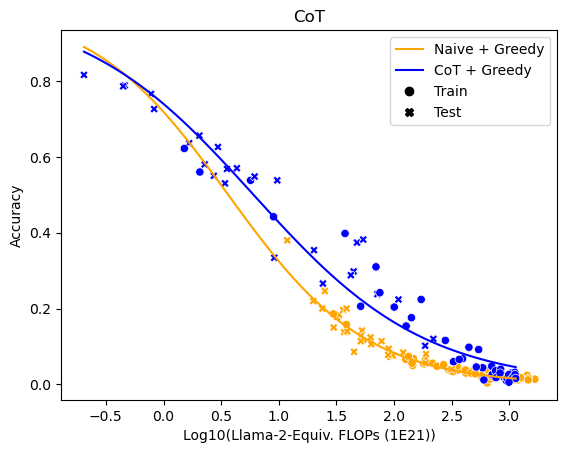

In [8]:
leaderboard3, w_f1, b_f1 = compute_f_equivalent_flops(leaderboard1,
                                                     beta=params1[0], 
                                                     alpha=params1[1],
                                                     benchmark='gsm8k_5_exact_match,flexible-extract')
leaderboard3, w_f2, b_f2 = compute_f_equivalent_flops(leaderboard2,
                                                     beta=params2[0], 
                                                     alpha=params2[1],
                                                     benchmark='gsm8k_cot_8_exact_match,flexible-extract')


fitted_scaling_law_with_equiv_scale(leaderboard1=leaderboard1,
                                    leaderboard2=leaderboard2,
                                    benchmark1='gsm8k_5_exact_match,flexible-extract',
                                    benchmark2='gsm8k_cot_8_exact_match,flexible-extract',
                                    params1=params1,
                                    params2=params2,
                                    wb1=[w_f1, b_f1],
                                    wb2=[w_f2, b_f2])